In [1]:
%load_ext autoreload
%autoreload 2

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
#import pymaise 
print("hi")


2024-05-13 17:20:05.441879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 17:20:05.441912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 17:20:05.456325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 17:20:05.491476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 17:20:06.213463: W tensorflow/compiler/tf2

hi


In [2]:
import psutil
import GPUtil

def get_gpu_utilization():
    # Get the list of available GPUs
    gpus = GPUtil.getGPUs()
    
    if len(gpus) == 0:
        print("No GPU found.")
        return
    
    for gpu in gpus:
        print(f"GPU {gpu.id}:")
        print(f"  - GPU name: {gpu.name}")
        print(f"  - GPU load: {gpu.load * 100:.2f}%")
        print(f"  - GPU memory total: {gpu.memoryTotal} MB")
        print(f"  - GPU memory used: {gpu.memoryUsed} MB")
        print(f"  - GPU memory free: {gpu.memoryFree} MB")
        print(f"  - GPU memory utilization: {gpu.memoryUtil * 100:.2f}%")
        print()

def main():
    # Print CPU utilization
    print("CPU utilization:", psutil.cpu_percent(interval=1))
    
    # Print GPU utilization
    get_gpu_utilization()

if __name__ == "__main__":
    main()


CPU utilization: 0.2
GPU 0:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 24060.0 MB
  - GPU memory free: 157.0 MB
  - GPU memory utilization: 97.95%

GPU 1:
  - GPU name: NVIDIA GeForce RTX 4090
  - GPU load: 0.00%
  - GPU memory total: 24564.0 MB
  - GPU memory used: 944.0 MB
  - GPU memory free: 23273.0 MB
  - GPU memory utilization: 3.84%



In [3]:
from pyMAISE.datasets import load_anomaly
from pyMAISE.preprocessing import train_test_split, scale_data, one_hot_encode, SplitSequence
import pyMAISE as mai

In [4]:
%%time

global_settings = mai.init(
    problem_type=mai.ProblemType.CLASSIFICATION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only/ Delete line when run on GPU
   # verbosity = 3
)

CPU times: user 24 µs, sys: 36 µs, total: 60 µs
Wall time: 62.5 µs


In [5]:
# call handler
input_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL.npy"
output_path = "/home/jacc/pyMAISE/pyMAISE/datasets/DTL_labels.npy"
#print(mai.__file__)
#False, False, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)  one hot
#False, True, False: WORKS       X.shape = (1077, 4500, 14), Y.shape = (1077, 1)
#False, False, True:  ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#False, True, True:   ?      X.shape = (1077, 4500, 14), Y.shape = (1077, 4500, 1)
#True, False, True: WORKS        X.shape = (4846500, 14), Y.shape = (4846500, 1)
#True, True, True: WORKS         X.shape = (4846500, 14), Y.shape = (4846500, 1)
cond1 = True
cond2 = False
cond3 = True
inputs, outputs = load_anomaly([input_path, output_path], cond1, cond2, cond3)


In [6]:
inputs

<xarray.DataArray (timesteps: 4846500, features: 14)>
array([[-6.07100e+00,  5.55120e+00, -1.42220e+00, ..., -4.60370e-02,
         2.17170e+03,  1.27100e+00],
       [-4.85030e+00,  4.33040e+00, -2.64290e+00, ...,  1.50000e-02,
         2.17250e+03, -1.33776e+01],
       [-4.85030e+00,  1.88890e+00, -1.42220e+00, ...,  4.55190e-02,
         2.17320e+03, -8.49500e+00],
       ...,
       [-2.17470e+00, -7.57620e+00, -3.39550e+00, ..., -1.07070e-01,
         2.17220e+03,  1.19730e+01],
       [-4.61620e+00, -3.91400e+00, -5.83700e+00, ..., -1.68110e-01,
         2.17180e+03,  9.53200e+00],
       [-3.39550e+00, -6.35550e+00, -5.83700e+00, ..., -4.60370e-02,
         2.17150e+03,  9.53200e+00]], dtype=float32)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U18 'A+IGBT-I: current' ... 'DV/DT'

In [7]:
outputs

<xarray.DataArray (timesteps: 4846500, features: 1)>
array([['Run'],
       ['Run'],
       ['Run'],
       ...,
       ['Fault'],
       ['Fault'],
       ['Fault']], dtype=object)
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) <U5 'Class'

In [8]:
outputs = one_hot_encode(outputs)
outputs

<xarray.DataArray (timesteps: 4846500, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'Class_Fault' 'Class_Run'

In [9]:
data = xr.concat([inputs, outputs], dim="features")
data

<xarray.DataArray (timesteps: 4846500, features: 16)>
array([[ -6.0710001 ,   5.55119991,  -1.42219996, ...,   1.27100003,
          0.        ,   1.        ],
       [ -4.85029984,   4.33039999,  -2.64289999, ..., -13.37759972,
          0.        ,   1.        ],
       [ -4.85029984,   1.88890004,  -1.42219996, ...,  -8.49499989,
          0.        ,   1.        ],
       ...,
       [ -2.17470002,  -7.57620001,  -3.39549994, ...,  11.97299957,
          1.        ,   0.        ],
       [ -4.61619997,  -3.91400003,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ],
       [ -3.39549994,  -6.35550022,  -5.83699989, ...,   9.53199959,
          1.        ,   0.        ]])
Coordinates:
  * timesteps  (timesteps) int64 0 1 2 3 4 ... 4846496 4846497 4846498 4846499
  * features   (features) object 'A+IGBT-I: current' ... 'Class_Run'

In [10]:
split_sequence = SplitSequence(
    10, 
    1, 
    0, 
    sequence_inputs=data.coords["features"].values[:-2], 
    sequence_outputs=data.coords["features"].values[-2:],
)
inputs, outputs = split_sequence.split(data)

inputs

<xarray.DataArray (samples: 4846491, timesteps: 10, features: 14)>
array([[[-6.07100010e+00,  5.55119991e+00, -1.42219996e+00, ...,
         -4.60369997e-02,  2.17169995e+03,  1.27100003e+00],
        [-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        ...,
        [-3.62960005e+00,  1.88890004e+00, -5.08440018e+00, ...,
         -4.60369997e-02,  2.17239990e+03, -1.17100000e+00],
        [-7.29180002e+00,  1.88890004e+00, -3.86360002e+00, ...,
          1.49999997e-02,  2.17230005e+03, -1.33781004e+01],
        [-7.29180002e+00,  3.10969996e+00, -2.64289999e+00, ...,
         -4.60369997e-02,  2.17280005e+03, -1.17100000e+00]],

       [[-4.85029984e+00,  4.33039999e+00, -2.64289999e+00, ...,
          1.49999997e-02,  2.17250000e+03, -1.33775997e+01],
        [-4.85029984e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17319995e+03, -8.49499989e+00],
        [-7.29180002e+00,  1.88890004e+00, -1.42219996e+00, ...,
          4.55190018e-02,  2.17300000e+03, -2.31439991e+01],
...
        [-4.61619997e+00, -8.79699993e+00, -4.61619997e+00, ...,
          1.49999997e-02,  2.17180005e+03,  4.64900017e+00],
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00]],

       [[-7.05770016e+00, -7.57620001e+00, -3.39549994e+00, ...,
          1.06559999e-01,  2.17180005e+03,  7.09000015e+00],
        [-4.61619997e+00, -6.35550022e+00, -7.05770016e+00, ...,
         -4.60369997e-02,  2.17160010e+03,  7.09100008e+00],
        [-3.39549994e+00, -8.79699993e+00, -2.17470002e+00, ...,
         -4.60369997e-02,  2.17180005e+03,  1.19740000e+01],
        ...,
        [-2.17470002e+00, -7.57620001e+00, -3.39549994e+00, ...,
         -1.07069999e-01,  2.17219995e+03,  1.19729996e+01],
        [-4.61619997e+00, -3.91400003e+00, -5.83699989e+00, ...,
         -1.68109998e-01,  2.17180005e+03,  9.53199959e+00],
        [-3.39549994e+00, -6.35550022e+00, -5.83699989e+00, ...,
         -4.60369997e-02,  2.17150000e+03,  9.53199959e+00]]])
Coordinates:
  * samples    (samples) int64 0 1 2 3 4 ... 4846487 4846488 4846489 4846490
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler






In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(inputs, outputs, test_size=0.3)



In [13]:
xtrain, xtest, x_scaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())



In [14]:
ytrain, ytest, y_scaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

In [15]:
%%time


xtrain = xtrain#[:8000]
ytrain = ytrain#[:8000]

xtest = xtest#[:2000]
ytest = ytest#[:2000]


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


In [16]:
xtrain.shape

(3392543, 10, 14)

In [17]:
ytrain.shape[-1]

2

In [18]:
lstm_structure = {
    "LSTM_input": {
        "units": 50,
        "return_sequences": True,
        "input_shape": (xtrain.shape[1], xtrain.shape[2]),
    },
    "LSTM": {
        "num_layers": mai.Int(min_value=0, max_value=3),
        "units": 50,
        "return_sequences": True,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
    },
#check activation to lstm to classification
    "LSTM_output": {
        "units": 50,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",

        
    },
    "Dense":{
         "num_layers": mai.Int(min_value=0, max_value=3),
         "units": mai.Int(min_value=25, max_value=250),
         "activation": "sigmoid", #do research on relu activation CHANGED
         "kernel_initializer": "normal",
         "sublayer": mai.Choice(["Dropout_hidden", "None"]),
         "Dropout_hidden": {
         "rate": mai.Float(min_value=0.4, max_value=0.6),}
    },
    "Dense_output": {
        "units": ytrain.shape[1],
        "activation": "softmax",
    },
}
#change nodes in each layer, not in the output
fitting = {
    "batch_size":128,# mai.Choice([16, 32, 64]), changed dfrom 128
    "epochs": 5,
    "validation_split":0.15,
    "callbacks": [
        ReduceLROnPlateau(
            monitor='accuracy',
            factor=0.8,
            patience=2,
            min_lr=0,
            verbose=1,
        ),
        EarlyStopping(
            monitor="accuracy",
            patience=3,
        )
    ]
}
adam = {
    "learning_rate": mai.Float(min_value=0.00001, max_value=0.001),
   # "clipnorm": mai.Float(min_value=0.8, max_value=1.2),
  #  "clipvalue": mai.Float(min_value=0.3, max_value=0.7),
}
compiling = {
    "loss": "binary_crossentropy",#figure out accuracy on keras keras lstm on classification
    "metrics": ["accuracy"],
}

model_settings = {
    "models": ["LSTM"],
    "LSTM": {
        "structural_params": lstm_structure,
        "optimizer": "Adam",
        "Adam": adam,
        "compile_params": compiling,
        "fitting_params": fitting,
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

In [19]:
xtrain.shape

(3392543, 10, 14)

In [20]:
lstm_structure

{'LSTM_input': {'units': 50,
  'return_sequences': True,
  'input_shape': (10, 14)},
 'LSTM': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x748120327490>,
  'units': 50,
  'return_sequences': True,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'LSTM_output': {'units': 50,
  'activation': 'tanh',
  'recurrent_activation': 'sigmoid'},
 'Dense': {'num_layers': <pyMAISE.utils.hyperparameters.Int at 0x7481211486d0>,
  'units': <pyMAISE.utils.hyperparameters.Int at 0x748121217c90>,
  'activation': 'sigmoid',
  'kernel_initializer': 'normal',
  'sublayer': <pyMAISE.utils.hyperparameters.Choice at 0x748120316110>,
  'Dropout_hidden': {'rate': <pyMAISE.utils.hyperparameters.Float at 0x748124258f10>}},
 'Dense_output': {'units': 2, 'activation': 'softmax'}}

In [21]:
ytrain.shape

(3392543, 2)

In [22]:

start = time.time()

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="accuracy_score",
    max_trials=5,
    cv=5,
)

print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Trial 5 Complete [03h 17m 28s]
accuracy_score: 0.9296689827291065

Best accuracy_score So Far: 0.9299481249837408
Total elapsed time: 11h 28m 06s
Hyperparameter tuning took 688.110727139314 minutes to process.


In [23]:
xtrain

<xarray.DataArray (samples: 3392543, timesteps: 10, features: 14)>
array([[[0.15218807, 0.6136534 , 0.79929869, ..., 0.51397968,
         0.95935777, 0.34553832],
        [0.16380434, 0.61429044, 0.79929869, ..., 0.51031161,
         0.95917687, 0.33463806],
        [0.17449429, 0.61524573, 0.79888775, ..., 0.50572665,
         0.95845361, 0.31774265],
        ...,
        [0.22766874, 0.61556424, 0.79970962, ..., 0.50480959,
         0.95849875, 0.32249913],
        [0.23805829, 0.61747482, 0.79847671, ..., 0.50205857,
         0.95881518, 0.31774265],
        [0.24844783, 0.61683805, 0.79929869, ..., 0.50068305,
         0.95913173, 0.29594213]],

       [[0.59562788, 0.01051281, 0.36121622, ..., 0.49334702,
         0.97590395, 0.32497646],
        [0.59409999, 0.01815617, 0.37353732, ..., 0.49059601,
         0.97513543, 0.33825498],
        [0.59532245, 0.01912136, 0.38794555, ..., 0.48601135,
         0.97554226, 0.34187187],
...
        [0.58437888, 0.60991057, 0.80068912, ..., 0.47959167,
         0.92798314, 0.64357133],
        [0.58468455, 0.61054747, 0.80068912, ..., 0.48050812,
         0.92735027, 0.63994005],
        [0.58468455, 0.60991057, 0.80068912, ..., 0.48142608,
         0.9277571 , 0.63389487]],

       [[0.59990654, 0.60696608, 0.80012056, ..., 0.49609803,
         0.91220548, 0.46286479],
        [0.59960094, 0.60855831, 0.80094247, ..., 0.49701494,
         0.91220548, 0.46044691],
        [0.59990654, 0.60792142, 0.80012056, ..., 0.49609803,
         0.91197944, 0.45923797],
        ...,
        [0.6008234 , 0.60823986, 0.80135344, ..., 0.49793199,
         0.91229588, 0.46891444],
        [0.59990654, 0.60887676, 0.80053153, ..., 0.49884904,
         0.91265756, 0.47012337],
        [0.6008234 , 0.6098321 , 0.80258629, ..., 0.49884904,
         0.91256712, 0.47133231]]])
Coordinates:
  * samples    (samples) int64 59386 2862875 2049316 ... 877907 1326391 368621
  * timesteps  (timesteps) int64 0 1 2 3 4 5 6 7 8 9
  * features   (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [24]:
ytrain.shape

(3392543, 2)

In [25]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 10}},
    },
  #  y_scaler=y_scaler,
)

In [26]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
0,LSTM,"{'LSTM_num_layers': 1, 'Dense_num_layers': 0, ...",0.931000,0.931000,0.931000,0.931000,0.930935,0.930935,0.930935,0.930935
1,LSTM,"{'LSTM_num_layers': 0, 'Dense_num_layers': 0, ...",0.930747,0.930747,0.930747,0.930747,0.930772,0.930772,0.930772,0.930772
2,LSTM,"{'LSTM_num_layers': 3, 'Dense_num_layers': 1, ...",0.929607,0.929607,0.929607,0.929607,0.929634,0.929634,0.929634,0.929634
3,LSTM,"{'LSTM_num_layers': 0, 'Dense_num_layers': 2, ...",0.921570,0.921570,0.921570,0.921570,0.921638,0.921638,0.921638,0.921638
4,LSTM,"{'LSTM_num_layers': 3, 'Dense_num_layers': 3, ...",0.852374,0.852374,0.852374,0.852374,0.852352,0.852352,0.852352,0.852352


In [27]:
for model in [ "LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: LSTM
LSTM_num_layers: 1
Dense_num_layers: 0
Adam_learning_rate: 0.00019160114914409392
Dense_0_units: 57
Dense_0_sublayer: Dropout_hidden
Dense_0_sublayer_Dropout_hidden_0_rate: 0.48819634570406495
Dense_1_units: 166
Dense_1_sublayer: None
Dense_1_sublayer_Dropout_hidden_0_rate: 0.40327194351955487



In [28]:
idx = postprocessor._get_idx()
idx

0

In [29]:
#postprocessor._models()
yhat_test = postprocessor._models["Test Yhat"][idx]

In [30]:
postprocessor.get_model()

In [31]:
 yhat_test

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [32]:
#postprocessor.confusion_matrix(model_type = "LSTM")
yhat_train = postprocessor._models["Train Yhat"][idx]
yhat_test = postprocessor._models["Test Yhat"][idx]


In [33]:
ytrain = postprocessor._ytrain.values
ytest = postprocessor._ytest.values

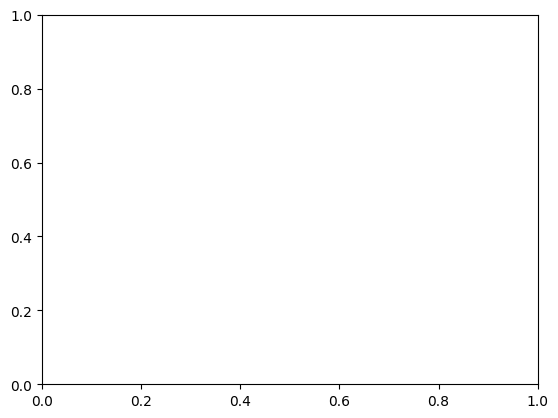

In [34]:
ax = plt.gca()

In [35]:
from sklearn.preprocessing import StandardScaler

ytrain = y_scaler.inverse_transform(
                ytrain.reshape(-1, ytrain.shape[-1])
            )
ytest = y_scaler.inverse_transform(ytest.reshape(-1, ytest.shape[-1]))

In [36]:
ytrain = np.round(ytrain).astype(int)
ytrain.shape

(3392543, 2)

In [37]:
yhat_train.shape

(3392543, 2)

In [38]:
yhat_train_single = np.argmax(yhat_train, axis=1)

In [39]:
ytrain_single = np.argmax(ytrain, axis=1)

In [40]:
yhat_train_single.shape

(3392543,)

In [41]:
ytrain_single.shape

(3392543,)

In [42]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(ytrain_single , yhat_train_single)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)


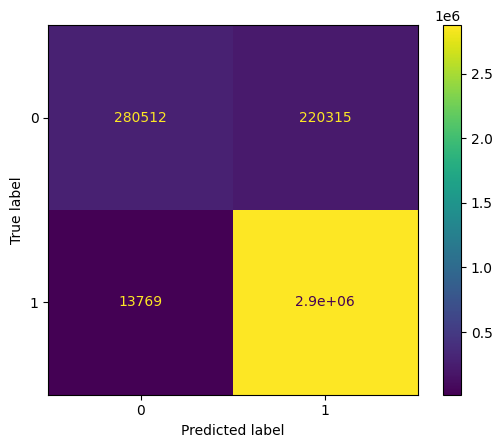

In [43]:
train_disp.plot()

In [44]:
ytest = np.round(ytest).astype(int)
ytest.shape

(1453948, 2)

In [45]:
yhat_test.shape

(1453948, 2)

In [46]:
yhat_test_single = np.argmax(yhat_test, axis=1)

In [47]:
ytest_single = np.argmax(ytest, axis=1)

In [48]:
yhat_test_single.shape

(1453948,)

In [49]:
ytest_single.shape

(1453948,)

In [50]:
test_cm = confusion_matrix(ytest_single, yhat_test_single)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)



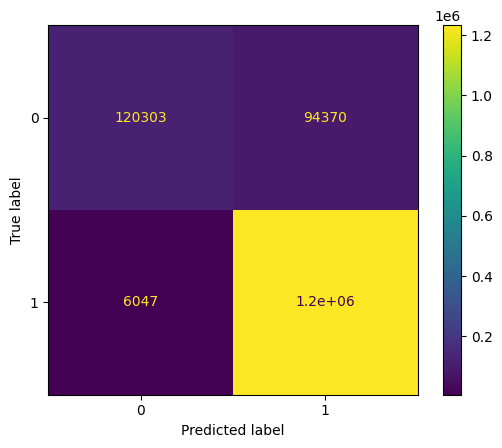

In [51]:
test_disp.plot()